# Q2) Predicting Food Delivery Time
In this question we are aksed to implement linear regression and gradient descent by working on a real-world dataset on food delivery time.

In [ ]:
# Importing the necessary libraries
import kaggle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import random

df = pd.read_csv('Food_Delivery_Times.csv')
print(df.isnull().sum())

Order_ID                   0
Distance_km                0
Weather                   30
Traffic_Level             30
Time_of_Day               30
Vehicle_Type               0
Preparation_Time_min       0
Courier_Experience_yrs    30
Delivery_Time_min          0
dtype: int64


Now we can see that the fields 'Weather', 'Traffic_Level', 'Time_of_Day' and 'Courier_Experience_yrs' are have null entires. Let us handle the missining values for each of these as follows:
1) If the field is a categorical field, we fill the misssing entries with the mode (most occuring) of the field
2) If the field is a numeric field, we fill the missing entries with the mean of the field

In [ ]:
categorical_fields = ['Weather', 'Traffic_Level', 'Time_of_Day']
for column in categorical_fields:
    try:
        df[column].fillna(df[column].mode()[0], inplace=True)
    except Exception as e:
        print('There seems to be an error:',e)

df['Courier_Experience_yrs'].fillna(df['Courier_Experience_yrs'].mean(), inplace=True)

# checking if there are any missing values
print(df.isnull().sum())

Order_ID                  0
Distance_km               0
Weather                   0
Traffic_Level             0
Time_of_Day               0
Vehicle_Type              0
Preparation_Time_min      0
Courier_Experience_yrs    0
Delivery_Time_min         0
dtype: int64


/tmp/ipykernel_25141/1683364439.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(df[column].mode()[0], inplace=True)
/tmp/ipykernel_25141/1683364439.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)

Now we are asked to encode the necessary fields. Encoding refers to the process of converting categorical (non-numeric) values into numeric values so that their usage becomes easier in methods like linear regression. For the categorical columns 'Weather', 'Vehicle_Type' and 'Time_of_Day' we go with the One-Hot Encoding and for 'Traffic_Level' we go with Ordinal Encoding

In [ ]:
# One-Hot encoding for the categorical fields 'Weather' and 'Time_of_Day'
weather_ohe = pd.get_dummies(df['Weather'], prefix='Weather')
df = pd.concat([df, weather_ohe], axis=1)
df.drop(columns=['Weather'], inplace=True)

time_of_day_ohe = pd.get_dummies(df['Time_of_Day'], prefix='Time_of_Day')
df = pd.concat([df, time_of_day_ohe], axis=1)
df.drop(columns=['Time_of_Day'], inplace=True)

vehicle_type_ohe = pd.get_dummies(df['Vehicle_Type'], prefix='Vehicle_Type')
df = pd.concat([df, vehicle_type_ohe], axis=1)
df.drop(columns=['Vehicle_Type'], inplace=True)

# Ordinal encoding for Traffic_Level
traffic_level_mapping = {'Low': 1, 'Medium': 2, 'High': 3}
df['Traffic_Level'] = df['Traffic_Level'].map(traffic_level_mapping)

Now let us plot the appropriate plots for each of the features. We go with histograms for numerical features. We use boxplots for outlier detection, violin plot for numerical distributions

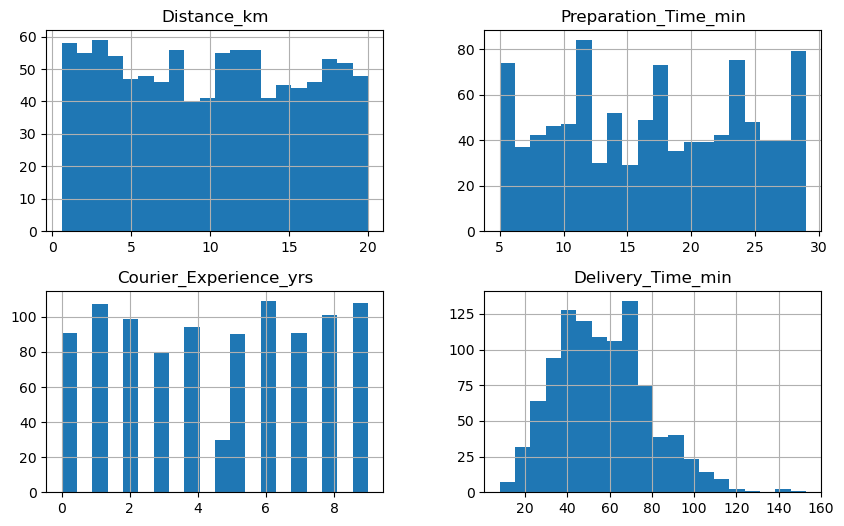

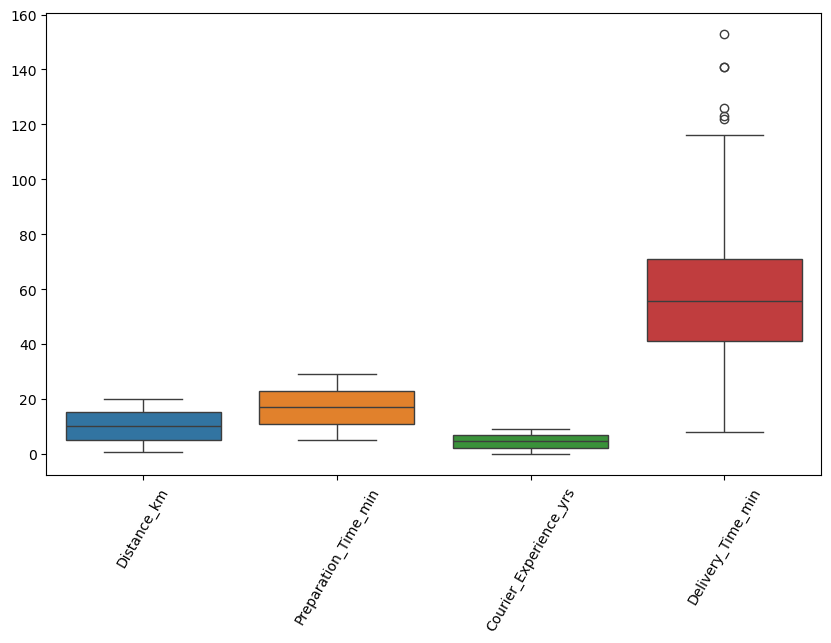

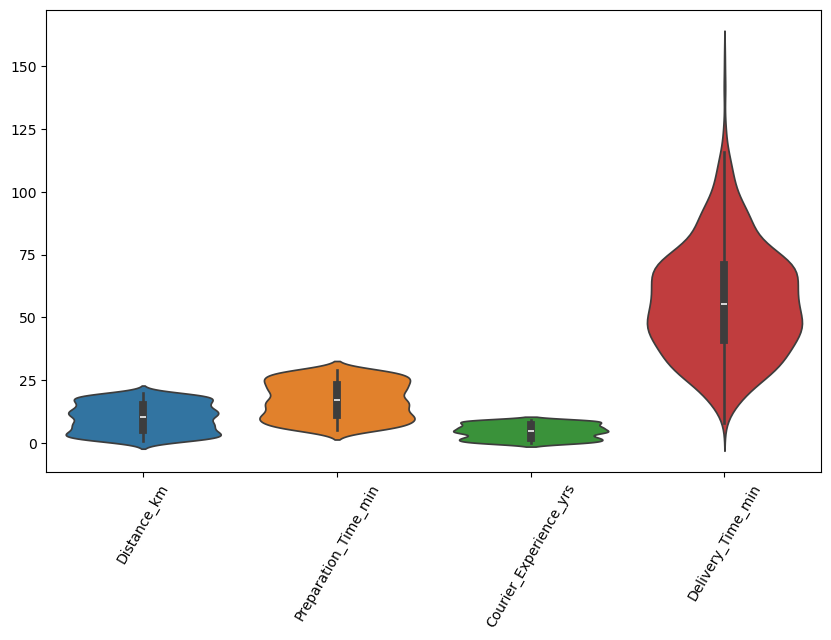

In [ ]:
# Histograms for the numeric fields
numeric_fields = ['Distance_km', 'Preparation_Time_min', 'Courier_Experience_yrs','Delivery_Time_min']
df[numeric_fields].hist(figsize=(10, 6), bins=20)
plt.show()

# Boxplots for outlier detection
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[numeric_fields])
plt.xticks(rotation=60)
plt.show()

# Violin  plots for numerical distributions
plt.figure(figsize=(10, 6))
sns.violinplot(data=df[numeric_fields])
plt.xticks(rotation=60)
plt.show()

Now let us split the dataset into train, test and validation sets as per the proportions 70:15:15. We are also asked to scale the features. Scaling refers to the process of 'normalizing' numerical values so that they have similar ragne. This prevents some features from dominating other (example: distance in Kms vs. preparation time in minutes). In our code we use the StandardScaler for normalizing the data, wherein we subtract the mean from the value and then divide by the standard deviation. Hence, after scaling scaling, the values have mean as 0 and standard deviation as 1

In [ ]:
# Splitting the dataset (70:15:15)
training_set, temp_data = train_test_split(df, test_size=0.3, random_state=42)
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Scaling the numerical fields
scaler = StandardScaler()

training_set[numeric_fields] = scaler.fit_transform(training_set[numeric_fields])

validation_data[numeric_fields] = scaler.transform(validation_data[numeric_fields])
test_data[numeric_fields] = scaler.transform(test_data[numeric_fields])

print(training_set.head())

     Order_ID  Distance_km  Traffic_Level  Preparation_Time_min  \
541       272     1.079578              1             -0.724620   
440       224    -0.439071              1             -1.144516   
482        12     1.626855              1             -0.864585   
422       484     0.453114              1              0.115171   
778       259     0.256023              1             -1.144516   

     Courier_Experience_yrs  Delivery_Time_min  Weather_Clear  Weather_Foggy  \
541               -1.245805           1.949758          False           True   
440               -0.901081          -1.201221          False          False   
482                1.167260           0.214436          False          False   
422               -1.590528           0.442768           True          False   
778                1.167260          -1.109889           True          False   

     Weather_Rainy  Weather_Snowy  Weather_Windy  Time_of_Day_Afternoon  \
541          False          False        

## 2.2) Linear Regression with Gradient Descent
Now we are asked to implement batch, mini-batch and stochastic gradient descent from scratch.
1) Batch Gradient Descent: uses all training samples to compute gradient in each step
2) Mini-Batch Gradient Descent: uses a small batch of samples to compute gradient
3) Stochastic Gradient Descent: updates weights for each individual sample

In [ ]:
# Let us define a function to initialize the weights and biases
def initialize_weights(features, random_init=True):
    if random_init:
        np.random.seed(7)
        weights = np.random.randn(features) * 0.01
        bias = np.random.randn() * 0.01
    else:
        weights = np.zeros(features)
        bias = 0
    return weights, bias

# Function to compute mean squared error
def compute_mse(true_y, pred_y):
    return np.mean((true_y - pred_y) ** 2)

# Function to compute the gradients
def compute_gradients(X, y, W, b):
    N = len(y)
    y_pred = X.dot(W) + b
    dW = (-2/N) * X.T.dot(y - y_pred)       # calculating the gradient of the loss function wrt weights
    db = (-2/N) * np.sum(y - y_pred)        # calculating the gradient of the loss function wrt bias
    return dW, db


# BATCH GRADIENT DESCENT
def batch_gradient_descent(X, y, alpha=0.05, epochs=1000):
    W, b = initialize_weights(X.shape[1])
    losses_list = []

    for i in range(epochs):
        dW, db = compute_gradients(X, y, W, b)
        W = W - alpha * dW
        b = b - alpha * db
        y_pred = X.dot(W) + b

        loss = compute_mse(y, y_pred)
        losses_list.append(loss)

        if i % 10 == 0:
            print(f'Epoch {i}, Loss: {loss}')
    return W, b, losses_list


# MINI-BATCH GRADIENT DESCENT
def mini_batch_gradient_descent(X, y, batch_size=32, alpha=0.05, epochs=1000):
    W, b = initialize_weights(X.shape[1])
    losses_list = []

    for i in range(epochs):
        for j in range(0, len(y), batch_size):
            X_batch = X[j:j + batch_size]
            y_batch = y[j:j + batch_size]

            dW, db = compute_gradients(X_batch, y_batch, W, b)
            W = W - alpha * dW
            b = b - alpha * db

        y_pred = X.dot(W) + b
        loss = compute_mse(y, y_pred)
        losses_list.append(loss)

        if i % 10 == 0:
            print(f'Epoch {i}, Loss: {loss}')
    return W, b, losses_list


# STOCHASTIC GRADIENT DESCENT
def stochastic_gradient_descent(X, y, alpha=0.05, epochs=1000):
    W, b = initialize_weights(X.shape[1])
    losses_list = []

    for i in range(epochs):
        indices = np.random.permutation(len(y))
        X_shuffled, y_shuffled = X[indices], y[indices]

        for j in range(len(y)):
            X_sample = X_shuffled[j:j+1]
            y_sample = y_shuffled[j:j+1]

            dW, db = compute_gradients(X_sample, y_sample, W, b)
            W = W - alpha * dW
            b = b - alpha * db

        loss = compute_mse(y, X.dot(W) + b)    
        losses_list.append(loss)

        if i % 10 == 0:
            print(f'Epoch {i}, Loss: {loss}')
    return W, b, losses_list

def stochastic_gradient_descent_decay(X, y, alpha=0.05, epochs=1000, decay_rate=0.001):
    W, b = initialize_weights(X.shape[1])
    losses_list = []

    for i in range(epochs):
        # Update learning rate using decay
        current_alpha = alpha / (1 + decay_rate * i)

        indices = np.random.permutation(len(y))
        X_shuffled, y_shuffled = X[indices], y[indices]

        for j in range(len(y)):
            X_sample = X_shuffled[j:j+1]
            y_sample = y_shuffled[j:j+1]

            dW, db = compute_gradients(X_sample, y_sample, W, b)
            W = W - current_alpha * dW
            b = b - current_alpha * db

        loss = compute_mse(y, X.dot(W) + b)    
        losses_list.append(loss)

        if i % 10 == 0:
            print(f'Epoch {i}, Learning Rate: {current_alpha:}, Loss: {loss}')
    
    return W, b, losses_list


Now let us test the above functions by training our model...

In [22]:
X_train = training_set.drop(columns=['Delivery_Time_min']).values
y_train = training_set['Delivery_Time_min'].values


# now let us train the models

# print('Training output for Batch Gradient Descent:')
# W_batch, b_batch, losses_batch = batch_gradient_descent(X_train, y_train, alpha=0.05, epochs=1000)
# print()
# print('Training output for Mini-Batch Gradient Descent:')
# W_mini_batch, b_mini_batch, losses_mini_batch = mini_batch_gradient_descent(X_train, y_train, alpha=0.05, epochs=1000, batch_size=32)
# print()

# # note that stochastic gradient descent is very sensitive to noise, hence we consider a very small value of alpha (learning rate) 
# print('Training outpu for Stochastic Gradient Descent:')
# W_sto, b_sto, losses_sto = stochastic_gradient_descent(X_train, y_train, alpha=0.05, epochs=1000)


print('Training output for Batch Gradient Descent:')
W_batch, b_batch, losses_batch = batch_gradient_descent(X_train, y_train, alpha=0.000001, epochs=5000)
print()
print('Training output for Mini-Batch Gradient Descent:')
W_mini_batch, b_mini_batch, losses_mini_batch = mini_batch_gradient_descent(X_train, y_train, alpha=0.000001, epochs=5000, batch_size=32)
print()

# note that stochastic gradient descent is very sensitive to noise, hence we consider a very small value of alpha (learning rate) 
print('Training output for Stochastic Gradient Descent:')
W_sto, b_sto, losses_sto = stochastic_gradient_descent_decay(X_train, y_train, alpha=0.00000000001, epochs=5000)

Training output for Batch Gradient Descent:
Epoch 0, Loss: 10.977672340631823
Epoch 10, Loss: 1.0037558323419513
Epoch 20, Loss: 1.0037270833358298
Epoch 30, Loss: 1.0036983367216705
Epoch 40, Loss: 1.0036695912630214
Epoch 50, Loss: 1.0036408469598308
Epoch 60, Loss: 1.0036121038120538
Epoch 70, Loss: 1.00358336181964
Epoch 80, Loss: 1.0035546209825423
Epoch 90, Loss: 1.0035258813007153
Epoch 100, Loss: 1.0034971427741084
Epoch 110, Loss: 1.003468405402675
Epoch 120, Loss: 1.0034396691863687
Epoch 130, Loss: 1.0034109341251363
Epoch 140, Loss: 1.0033822002189372
Epoch 150, Loss: 1.0033534674677183
Epoch 160, Loss: 1.0033247358714368
Epoch 170, Loss: 1.0032960054300402
Epoch 180, Loss: 1.0032672761434804
Epoch 190, Loss: 1.003238548011714
Epoch 200, Loss: 1.0032098210346907
Epoch 210, Loss: 1.0031810952123617
Epoch 220, Loss: 1.0031523705446819
Epoch 230, Loss: 1.0031236470316025
Epoch 240, Loss: 1.0030949246730756
Epoch 250, Loss: 1.0030662034690525
Epoch 260, Loss: 1.0030374834194877

Now let us plot the loss function (MSE) vs. the number of interations for each gradient descent method

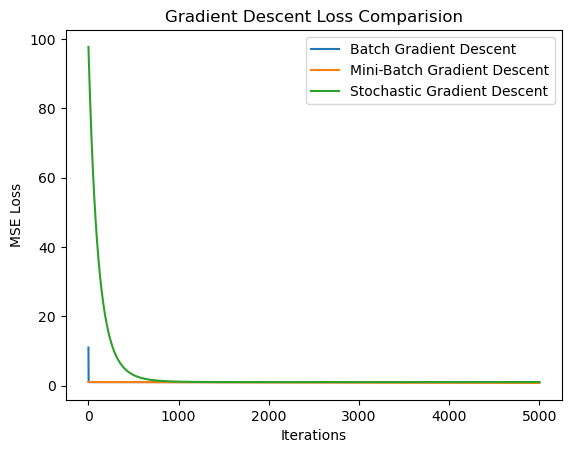

In [23]:
# Ploting the loss function vs number of iterations
plt.plot(losses_batch, label='Batch Gradient Descent')
plt.plot(losses_mini_batch, label='Mini-Batch Gradient Descent')
plt.plot(losses_sto, label='Stochastic Gradient Descent')
plt.xlabel('Iterations')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Gradient Descent Loss Comparision')
plt.show()

Now let us compare the MSE and R-2 score for test data for each method...

In [24]:
X_test = test_data.drop(columns=['Delivery_Time_min']).values
y_test = test_data['Delivery_Time_min'].values

# Predictions
y_predicted_batch = X_test.dot(W_batch) + b_batch
y_predicted_mini_batch = X_test.dot(W_mini_batch) + b_mini_batch
y_predicted_sto = X_test.dot(W_sto) + b_sto

# Computing the MSE and R-2 scores
print("Batch Gradient Descent - MSE:", mean_squared_error(y_test, y_predicted_batch), "R² Score:", r2_score(y_test, y_predicted_batch))
print("Mini-Batch Gradient Descent - MSE:", mean_squared_error(y_test, y_predicted_mini_batch), "R² Score:", r2_score(y_test, y_predicted_mini_batch))
print("Stochastic Gradient Descent - MSE:", mean_squared_error(y_test, y_predicted_sto), "R² Score:", r2_score(y_test, y_predicted_sto))

Batch Gradient Descent - MSE: 0.8645672754884458 R² Score: 0.0015030503696660258
Mini-Batch Gradient Descent - MSE: 0.6187881672172612 R² Score: 0.2853556745081345
Stochastic Gradient Descent - MSE: 0.8789144856160467 R² Score: -0.01506667873559242


## 2.3) Regularization
We now are asked to regularize the models using L1 (Lasso) and L2 (Ridge) regressions. Regularization is a process incorporated to avoid over-fitting by adding a penalty term to the models and hence, improve predictive performance. We are asked to train the linear model using the stochastic gradient descent.

In [25]:
# Modified Stochastic Gradient Descent function
def stochastic_gradient_descent_ridge(X, y, alpha=0.05, epochs=5000, lambda_val=0.5):
    W, b = initialize_weights(X.shape[1])
    losses_list = []

    for i in range(epochs):
        indices = np.random.permutation(len(y))
        X_shuffled, y_shuffled = X[indices], y[indices]

        for j in range(len(y)):
            X_sample = X_shuffled[j:j+1]
            y_sample = y_shuffled[j:j+1]

            dW, db = compute_gradients(X_sample, y_sample, W, b)
            W = W - alpha * (dW + lambda_val * W)                       # Ridge penality
            b = b - alpha * db

        loss = compute_mse(y, X.dot(W) + b)    
        losses_list.append(loss)

        if i % 10 == 0:
            print(f'Epoch {i}, Loss: {loss}')
    return W, b, losses_list


def stochastic_gradient_descent_lasso(X, y, alpha=0.05, epochs=5000, lambda_val=0.5):
    W, b = initialize_weights(X.shape[1])
    losses_list = []

    for i in range(epochs):
        indices = np.random.permutation(len(y))
        X_shuffled, y_shuffled = X[indices], y[indices]

        for j in range(len(y)):
            X_sample = X_shuffled[j:j+1]
            y_sample = y_shuffled[j:j+1]

            dW, db = compute_gradients(X_sample, y_sample, W, b)
            W = W - alpha * (dW + lambda_val * np.sign(W))              # Lasso penality
            b = b - alpha * db

        loss = compute_mse(y, X.dot(W) + b)    
        losses_list.append(loss)

        if i % 10 == 0:
            print(f'Epoch {i}, Loss: {loss}')
    return W, b, losses_list

print('Training outpu for Stochastic Gradient Descent with Ridge Regularization:')
W_sto, b_sto, losses_sto = stochastic_gradient_descent_ridge(X_train, y_train, alpha=0.00000000001, epochs=5000)
print()

print('Training outpu for Stochastic Gradient Descent with Lasso Regularization:')
W_sto, b_sto, losses_sto = stochastic_gradient_descent_lasso(X_train, y_train, alpha=0.00000000001, epochs=5000)

Training outpu for Stochastic Gradient Descent with Ridge Regularization:
Epoch 0, Loss: 97.69745431806017
Epoch 10, Loss: 88.91234663550246
Epoch 20, Loss: 80.92544297326272
Epoch 30, Loss: 73.66414791083443
Epoch 40, Loss: 67.0626040480187
Epoch 50, Loss: 61.0608308768059
Epoch 60, Loss: 55.60434930101898
Epoch 70, Loss: 50.64362933041035
Epoch 80, Loss: 46.13360087099182
Epoch 90, Loss: 42.03332010620133
Epoch 100, Loss: 38.30557885898602
Epoch 110, Loss: 34.91651733338985
Epoch 120, Loss: 31.835387190202578
Epoch 130, Loss: 29.034179290564907
Epoch 140, Loss: 26.487478192984177
Epoch 150, Loss: 24.172158394267623
Epoch 160, Loss: 22.067187909798037
Epoch 170, Loss: 20.15346540190385
Epoch 180, Loss: 18.413614103607827
Epoch 190, Loss: 16.831842240791225
Epoch 200, Loss: 15.393799278690507
Epoch 210, Loss: 14.086392303127727
Epoch 220, Loss: 12.897769082264588
Epoch 230, Loss: 11.817140733950122
Epoch 240, Loss: 10.834702669198542
Epoch 250, Loss: 9.941521347973504
Epoch 260, Loss: 

Now let us repeat this for 10 random values of lambda that lie in the range 0 and 1. We shall also plot the test MSE vs. lambda and analyze the impact of regualrization strength on model performance and overfitting.

In [26]:
# Generating 10 random values of lambda (penalty parameter)
random_lambdas = [random.random() for _ in range(10)]
print('The lambdas we are considering are as follows:',random_lambdas)

ridge_mse, lasso_mse = [], []

for i in random_lambdas:
    print(f'Training Ridge Regression with λ = {i}')
    W_ridge, b_ridge, _ = stochastic_gradient_descent_ridge(X_train, y_train, alpha=0.00000000001, epochs=5000, lambda_val=i)
    print()
    print(f'Training Lasso Regression with λ = {i}')
    W_lasso, b_lasso, _ = stochastic_gradient_descent_lasso(X_train, y_train, alpha=0.00000000001, epochs=5000, lambda_val=i)

    y_predicted_ridge = X_test.dot(W_ridge) + b_ridge
    y_predicted_lasso = X_test.dot(W_lasso) + b_lasso

    ridge_mse.append(mean_squared_error(y_test, y_predicted_ridge))
    lasso_mse.append(mean_squared_error(y_test, y_predicted_lasso))

The lambdas we are considering are as follows: [0.5187971619134123, 0.909502109158732, 0.22197050296354748, 0.08245330577269261, 0.6763406206818577, 0.3202450399301503, 0.5713221143618327, 0.3969421206888072, 0.22919730848534603, 0.6826407769878868]
Training Ridge Regression with λ = 0.5187971619134123
Epoch 0, Loss: 97.69745429267812
Epoch 10, Loss: 88.91234638168335
Epoch 20, Loss: 80.92544253275169
Epoch 30, Loss: 73.66414731967501
Epoch 40, Loss: 67.06260333724641
Epoch 50, Loss: 61.06083007305618
Epoch 60, Loss: 55.60434842707342
Epoch 70, Loss: 50.64362840567909
Epoch 80, Loss: 46.133599911936756
Epoch 90, Loss: 42.03331912671066
Epoch 100, Loss: 38.30557787070564
Epoch 110, Loss: 34.916516346018696
Epoch 120, Loss: 31.835386211747615
Epoch 130, Loss: 29.03417832757104
Epoch 140, Loss: 26.487477250732514
Epoch 150, Loss: 24.172157476950556
Epoch 160, Loss: 22.067187020674293
Epoch 170, Loss: 20.15346454343444
Epoch 180, Loss: 18.413613277572313
Epoch 190, Loss: 16.83184144839239


Let us now plot test MSE vs. lambda...

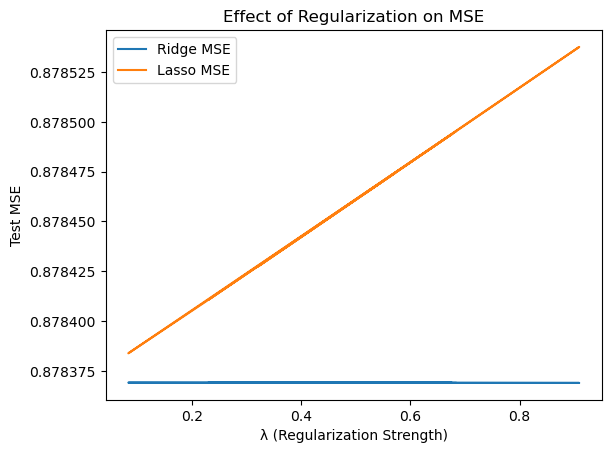

In [29]:
plt.plot(random_lambdas, ridge_mse, label="Ridge MSE")
plt.plot(random_lambdas, lasso_mse, label="Lasso MSE")
plt.xlabel("λ (Regularization Strength)")
plt.ylabel("Test MSE")
plt.legend()
plt.title("Effect of Regularization on MSE")
plt.show()

## 2.4) Report
We are asked to plot the line of best fit with the true values for train, test and validation set

Test Data


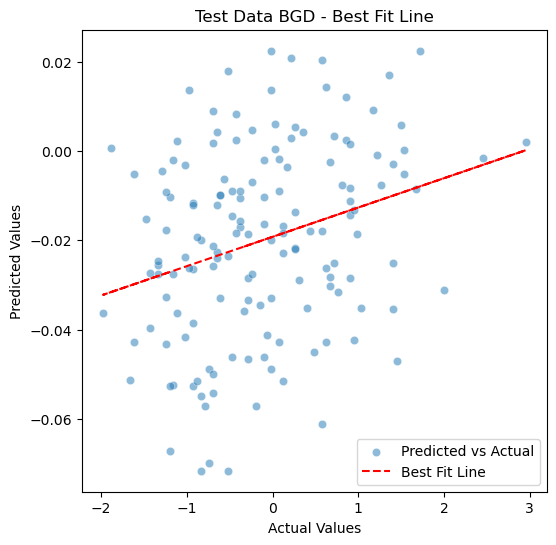

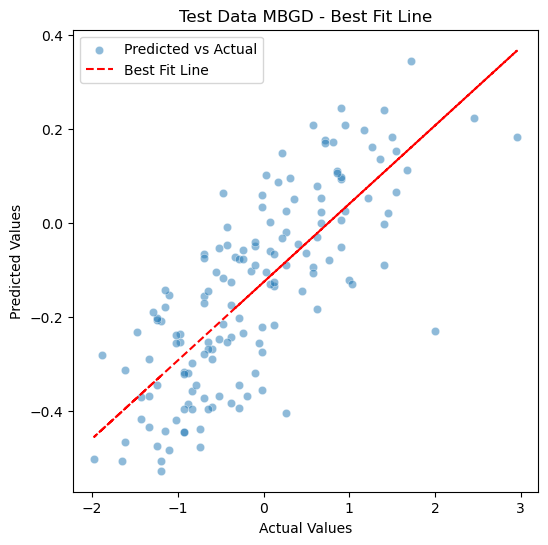

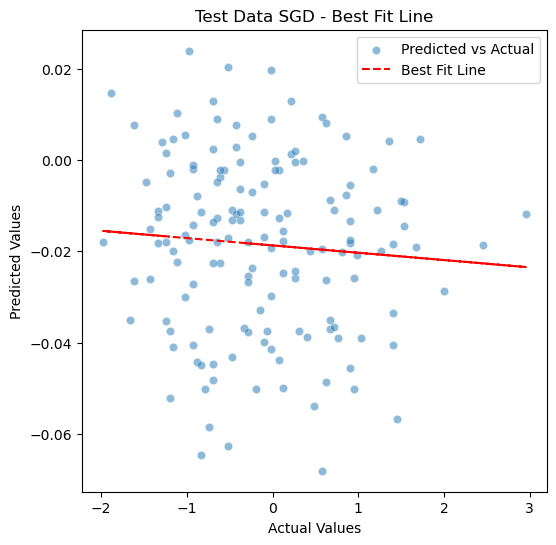

Train Data


ValueError: All arrays must be of the same length

<Figure size 600x600 with 0 Axes>

In [30]:
def line_of_best_fit(y_true, y_predicted, title):
    plt.figure(figsize=(6,6))
    
    # Convert to NumPy arrays with float type
    y_true = np.array(y_true, dtype=np.float64)
    y_predicted = np.array(y_predicted, dtype=np.float64)

    # Scatter plot of actual vs predicted values
    sns.scatterplot(x=y_true, y=y_predicted, alpha=0.5, label="Predicted vs Actual")

    # Compute line of best fit
    a, b = np.polyfit(y_true, y_predicted, 1)  # Find slope & intercept
    plt.plot(y_true, a * y_true + b, color='red', linestyle='--', label="Best Fit Line")  

    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(title)
    plt.legend()
    plt.show()

# Call function
print('Test Data')
line_of_best_fit(y_test, y_predicted_batch, "Test Data BGD - Best Fit Line")
line_of_best_fit(y_test, y_predicted_mini_batch, "Test Data MBGD - Best Fit Line")
line_of_best_fit(y_test, y_predicted_sto, "Test Data SGD - Best Fit Line")

print('Train Data')
line_of_best_fit(y_train, y_predicted_batch, 'Train Data BGD - Best Fit Line')
line_of_best_fit(y_train, y_predicted_mini_batch, "Train Data MBGD - Best Fit Line")
line_of_best_fit(y_train, y_predicted_sto, "Train Data SGD - Best Fit Line")